<a href="https://colab.research.google.com/github/zuti666/generative-models/blob/master/ContionalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contional Gan 网络 pytorch 版本 代码实现

**论文信息**
[paper](https://arxiv.org/abs/1411.1784)



**示意图**

 ![img](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231003114022.png)

**主要思想**
>**解读**
>这篇论文中的Conditional GAN和[原生GAN](https://zhuanlan.zhihu.com/p/85504103)在结构上没有太大差别，时间也是紧随着原生GAN出来的，它的思想应该后续很多GAN网络的基础。简单来说，原生的GAN是无监督的，包括之前一篇介绍的[DCGAN](https://zhuanlan.zhihu.com/p/85833427)，输出是完全随机的，比如在人脸上训练好的网络，最后生成什么样的人脸是完全没办法控制的，所以在这篇文章中，作者在输入的时候加入了条件（类别标签或者其他模态的信息），比如在MNIST训练好的网络，可以指定生成某一个具体数字的图像，这就成了有监督的GAN。同时，在文章中，作者还使用网络进行了图像自动标注。

Conditional，意思是条件，所以 **Conditional GAN** 的意思就是有条件的GAN。Conditional GAN 可以让 GAN 产生的结果符合一定的条件，即可以通过人为改变输入的向量（记不记得我们让生成器生成结果需要输入一个低维向量），控制最终输出的结果。

这种网络与普通 GAN 的区别在于输入加入了一个额外的 condition（比如在 text-to-image 任务中的描述文本），并且在训练的时候使得输出的结果拟合这个 condition。

所以现在判别器不仅要对生成结果的质量打分，还要对结果与输入 condition 的符合程度打分。

判别器应该判别两类错误，

一类是 标签与生成结果匹配，但是图像效果不够好，这样子应该给低分

另一类是 标签与生成结果不匹配，这样子也应该给低分

只有 标签与生成结果匹配，并且图像效果足够好，才能给高分

**算法流程**


![image-20231003114353744](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231003114353.png)

**网络架构**

可以看到，和原始GAN一样，整体还是基于多层感知器。在原生GAN中，判别器的输入是训练样本x，生成器的的输入是噪声z，在conditional GAN中，生成器和判别器的输入都多了一个y，这个y就是那个条件。以手写字符数据集MNIST为例，这时候x代表图片向量，y代表图片类别对应的label(one-hot表示的0~9)。

![img](https://zuti.oss-cn-qingdao.aliyuncs.com/img/20231003114932.webp)

对于判别器D，训练的时候，输入的时候把训练样本x（或G产生的样本）和y同时输入，在第一个hidden layer后合并，最后的输出是在y的条件下训练样本x（或G产生的样本)是真样本的概率，然后反向优化。

对于生成器G，输入是噪声z和y,经过感知器最终输出产生的标签y对应的图片，然后把生成的图片和y送入判别器，进而反向优化。

**代码实现**

第一步 导入相关的库

In [2]:
# 导入所需的库
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torchvision import datasets, transforms

第二步 准备相关数据集，这里我们使用MINIST手写数字集合


In [3]:
# 定义MNIST数据集的变换
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 下载并加载MNIST数据集
mnist = datasets.MNIST('../../MNIST_data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=mb_size, shuffle=True, drop_last=True)



设置一些超参数

In [11]:
# 设置一些超参数
mb_size = 64  # 每一批次的大小
Z_dim = 100  # 输入的随机向量维度z
X_dim = 784  # MNIST图像的大小为28x28，所以展平后的维度为784
y_dim = 10   # MNIST数据集中有10个类别
h_dim = 128
c = 0    # 输入的生成条件c
file_name = 0 #生成图片的名称
lr = 1e-3  #学习率

创建 生成器 和判别器，注意这里生成器的输入为z和c ,判别器的输入也是z和c

In [5]:
# 生成器模型
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Linear(Z_dim + y_dim, h_dim)
        self.fc2 = torch.nn.Linear(h_dim, X_dim)

    def forward(self, z, c):
        inputs = torch.cat([z, c], 1)
        h = F.relu(self.fc1(inputs))
        X = torch.sigmoid(self.fc2(h))
        return X

# 判别器模型
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(X_dim + y_dim, h_dim)
        self.fc2 = torch.nn.Linear(h_dim, 1)

    def forward(self, X, c):
        inputs = torch.cat([X, c], 1)
        h = F.relu(self.fc1(inputs))
        y = torch.sigmoid(self.fc2(h))
        return y

In [6]:
# 创建生成器和判别器实例
G = Generator()
D = Discriminator()

# 优化器
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

In [7]:
def reset_grad():
    G.zero_grad()
    D.zero_grad()


为真实图片和生成结果设置不同的标签


In [8]:
ones_label = Variable(torch.ones(mb_size, 1))
zeros_label = Variable(torch.zeros(mb_size, 1))

训练循环

Iter-0; D_loss: 2.8000775273540057e-05; G_loss: 10.48801040649414


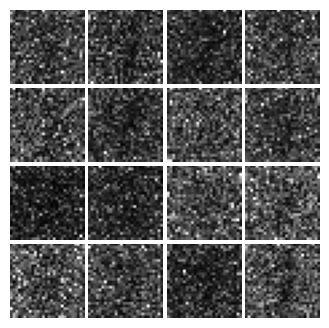

In [ ]:
# 训练循环
for it in range(100000):
    for X, y in data_loader:
        X = X.view(-1, X_dim)
        X = Variable(X)
        c = Variable(torch.zeros(mb_size, y_dim))
        c.scatter_(1, y.view(-1, 1), 1)  # 对标签进行独热编码

        # 判别器前向传播-损失-反向传播-更新
        z = Variable(torch.randn(mb_size, Z_dim))
        G_sample = G(z, c)
        D_real = D(X, c)
        D_fake = D(G_sample, c)

        D_loss_real = F.binary_cross_entropy(D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        D_solver.step()

        # 重置梯度
        reset_grad()

        # 生成器前向传播-损失-反向传播-更新
        z = Variable(torch.randn(mb_size, Z_dim))
        G_sample = G(z, c)
        D_fake = D(G_sample, c)

        G_loss = F.binary_cross_entropy(D_fake, ones_label)

        G_loss.backward()
        G_solver.step()

        # 重置梯度
        reset_grad()

    # 每隔一段时间打印和绘图
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        c = Variable(torch.zeros(mb_size, y_dim))
        c.scatter_(1, torch.randint(0, y_dim, (mb_size, 1)), 1)  # 随机选择一个类别
        samples = G(z, c).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(file_name).zfill(3)), bbox_inches='tight')
        file_name += 1
        plt.show()
        plt.close(fig)